# Urban Simulation Final

In [2]:
from random import choice, random, randint
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Silence FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
bld_shp_path = '/Users/noamgal/Downloads/bldgs_points (1)/bldgs_points.shp'

# Original Model With Completed TODOs

In [5]:
class Shop:    
    def __init__(self, geometry, quality, price, operation_costs):
        '''Create a Shop object, inputs:\n
        geometry = location of shop, Shapely geometry object\n
        quality = quality of product in the shop, float (range 0 to 1)\n
        price = price per product unit in the shop, int (range 0 to inf)\n
        operation_costs = total operation costs for the shop, int (range 0 to inf)'''
        
        self.geometry = geometry
        self.quality = quality
        self.price = price
        self.operation_costs = operation_costs
        
        self.revenue = 0 # used to keep track of revenue during each iteration
    
    def dist(self, geom):
        '''Compute aerial distance between object and geometry object geom'''
        
        return self.geometry.distance(geom)
    
    def step(self):
        '''Determines change in price according to shops revenue and operation costs'''
        
        model.revenues += self.revenue # increase model variable to document revenue
        if self.revenue < self.operation_costs: # if the shop is not profitable, decrease price
            self.price -= 1 # decrease price
            if self.price == 0: # if price is not positive - remove from model and agents' maps
                model.venues.remove(self) # delete object from model's list of venues
                for a in model.agents: # remove venue from agents' cognitive maps
                    del a.cognitive_map[self]
        elif self.revenue >= 2 * self.operation_costs: # if profits are high - increase price
            self.price += 1
        self.revenue = 0 # reset revenue for next round


class Agent:    
    def __init__(self, home, budget, consumption):
        '''Create an Agent object, inputs:\n
        home - home location, Shapely geometry object\n
        budget - agent's travel and consumption budget, int (range 0 to inf)\n
        consumption - agent's desired amount of product units to be purchased'''
        
        self.home = home
        self.budget = budget
        self.consumption = consumption
        
        self.cognitive_map = {} # initiate cognitive map
    
    def consume(self, v):
        '''Calculates consumption amount at given shop. Input: v - a Shop objects. Returns consumption amount - int. '''
        
        transport_costs = v.dist(self.home) * model.transportation_costs # compute cost of travelling to shop
        # compute the amount the agent will purchase given transport costs, budget, and price
        consumption_amount = int((self.budget-transport_costs) / v.price)
        if consumption_amount > self.consumption: # make sure consumption amount does not exceed the desired amount
            consumption_amount = self.consumption
        if consumption_amount < 0: # make sure consumption amount is not negative
            consumption_amount = 0
        return consumption_amount
        
    def compute_utility(self, v, quality): # input - a shop, quality level
        '''Computes the utility the agent gets or is expecting to get from shopping at venue v, inputs:\n
        v -  a Shop object\n
        quality - a quality score (either from cognitive map or real), float\n
        Returns utility (float)'''
        
        # TODO 1: compute consumption amount and consumption ratio, and return utility
        consumption_amount = self.consume(v)
        consumption_ratio = consumption_amount / self.consumption
        utility = consumption_ratio * (1 - model.w_quality) + quality * model.w_quality
        return utility
    
    def choose_venue(self):
        '''Chooses the venue visited by the agent at the current iteration. Returns v - a Shop object\n'''
        
        # TODO 2: Identify all Shops that produce enough utility, choose one of them randomly, and return it.
        # Utility is computed based on the agent's cognitive map and not actual quality
        # If no shop produces enough utility - randomly choose otu of all shops and return the chosen shop.
        candidates = [v for v in self.cognitive_map if self.compute_utility(v, self.cognitive_map[v]) >= model.utility_threshold]
        if not candidates:
            candidates = list(self.cognitive_map.keys())
        return choice(candidates)

    def step(self):
        ''''Agent step - choose a shop and consume at it, update cognitive map'''
        
        v = self.choose_venue() # choose the shop to visit
        consumption_amount = self.consume(v) # compute number of product units purchased there
        
        v.revenue += consumption_amount * v.price # update shop's revenue 
        # TODO 3: update agent belief about the shop quality to be the average of the current belief and the actual quality
        
        model.utilities += self.compute_utility(v, v.quality) # get actual utility from the purchase and document it
        model.distances += v.dist(self.home) # document travel distance from agent's home
        
        self.cognitive_map[v] = (self.cognitive_map[v] + v.quality) / 2

class Model:    
    def __init__(self, transportation_costs, gdf, sim):
        '''Create a Model object. Inputs: transportation costs parameter value (int), gdf - GeoDataFrame of building locations and uses, 
        simulation number (int)'''
        
        # set parameter values
        self.transportation_costs = transportation_costs # travel tax rate
        self.w_quality = 0.5 # weight of quality in utility function
        self.utility_threshold = 0.6 # minimal utility agents look for in venue
        self.sim = sim # simulation number
        
        # create venues based on commercial buildings in the GeoDataFrame
        self.venues = [Shop(row.geometry, random(), randint(10, 50), randint(1000, 10000)) for idx, row in gdf.iterrows() if row.landuse=='commercial']
        # create agents located inside residential buildings
        self.agents = [Agent(row.geometry, randint(200, 400), randint(1, 10)) for idx, row in gdf.iterrows() if row.landuse!='commercial']        
        
        for a in self.agents: # initiate agent's cognitive maps with random quality value for all venues
            a.cognitive_map = {v:random() for v in self.venues}
        
        self.data = [] # used to store model outputs
    
    def run_model(self):
        '''Runs 100 simulation iterations and stores outputs in the data attribute'''
        
        for i in range(100): # run 100 iterations
            # reset output variables
            self.utilities = 0 
            self.revenues = 0
            self.distances = 0
            
            for a in self.agents: # agents consume
                a.step()
            
            for b in self.venues: # shops update prices
                b.step()
            
            # compute mean utility, revenue, price, travel distance, and cognitive map accuracy
            mean_utility = self.utilities / len(self.agents)
            mean_revenue = self.revenues / len(self.venues)
            mean_price = sum([v.price for v in self.venues]) / len(self.venues)
            mean_distance = self.distances / len(self.agents)
            mean_accuracy = sum([1-abs(a.cognitive_map[v]-v.quality) for a in self.agents for v in self.venues]) / (len(self.agents) * len(self.venues))
            
            # append to data - transportation costs, simulation number, step number,
            # number of open shops, average utility derived from purchase per agent, 
            # average revenue per shop, average price per shop, average cognitive map accuracy
            self.data.append([self.transportation_costs, self.sim, i, 
                              len(self.venues), mean_utility, mean_revenue, mean_price, mean_distance, mean_accuracy])





In [6]:
results = []
# TODO 4: read 'bldgs_points' shapefile into a GeoDataFrame named gdf
gdf = gpd.read_file(bld_shp_path)

for transport_costs in [0, 0.2, 0.4, 0.6, 0.8, 1]: # iterate over values of transportation costs
    for i in range(10): # simulate 10 times
        print(transport_costs, i)
        model = Model(transport_costs, gdf, i)
        model.run_model()
        for d in model.data: # add outputs to results
            results.append(d)   

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0.2 0
0.2 1
0.2 2
0.2 3
0.2 4
0.2 5
0.2 6
0.2 7
0.2 8
0.2 9
0.4 0
0.4 1
0.4 2
0.4 3
0.4 4
0.4 5
0.4 6
0.4 7
0.4 8
0.4 9
0.6 0
0.6 1
0.6 2
0.6 3
0.6 4
0.6 5
0.6 6
0.6 7
0.6 8
0.6 9
0.8 0
0.8 1
0.8 2
0.8 3
0.8 4
0.8 5
0.8 6
0.8 7
0.8 8
0.8 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9


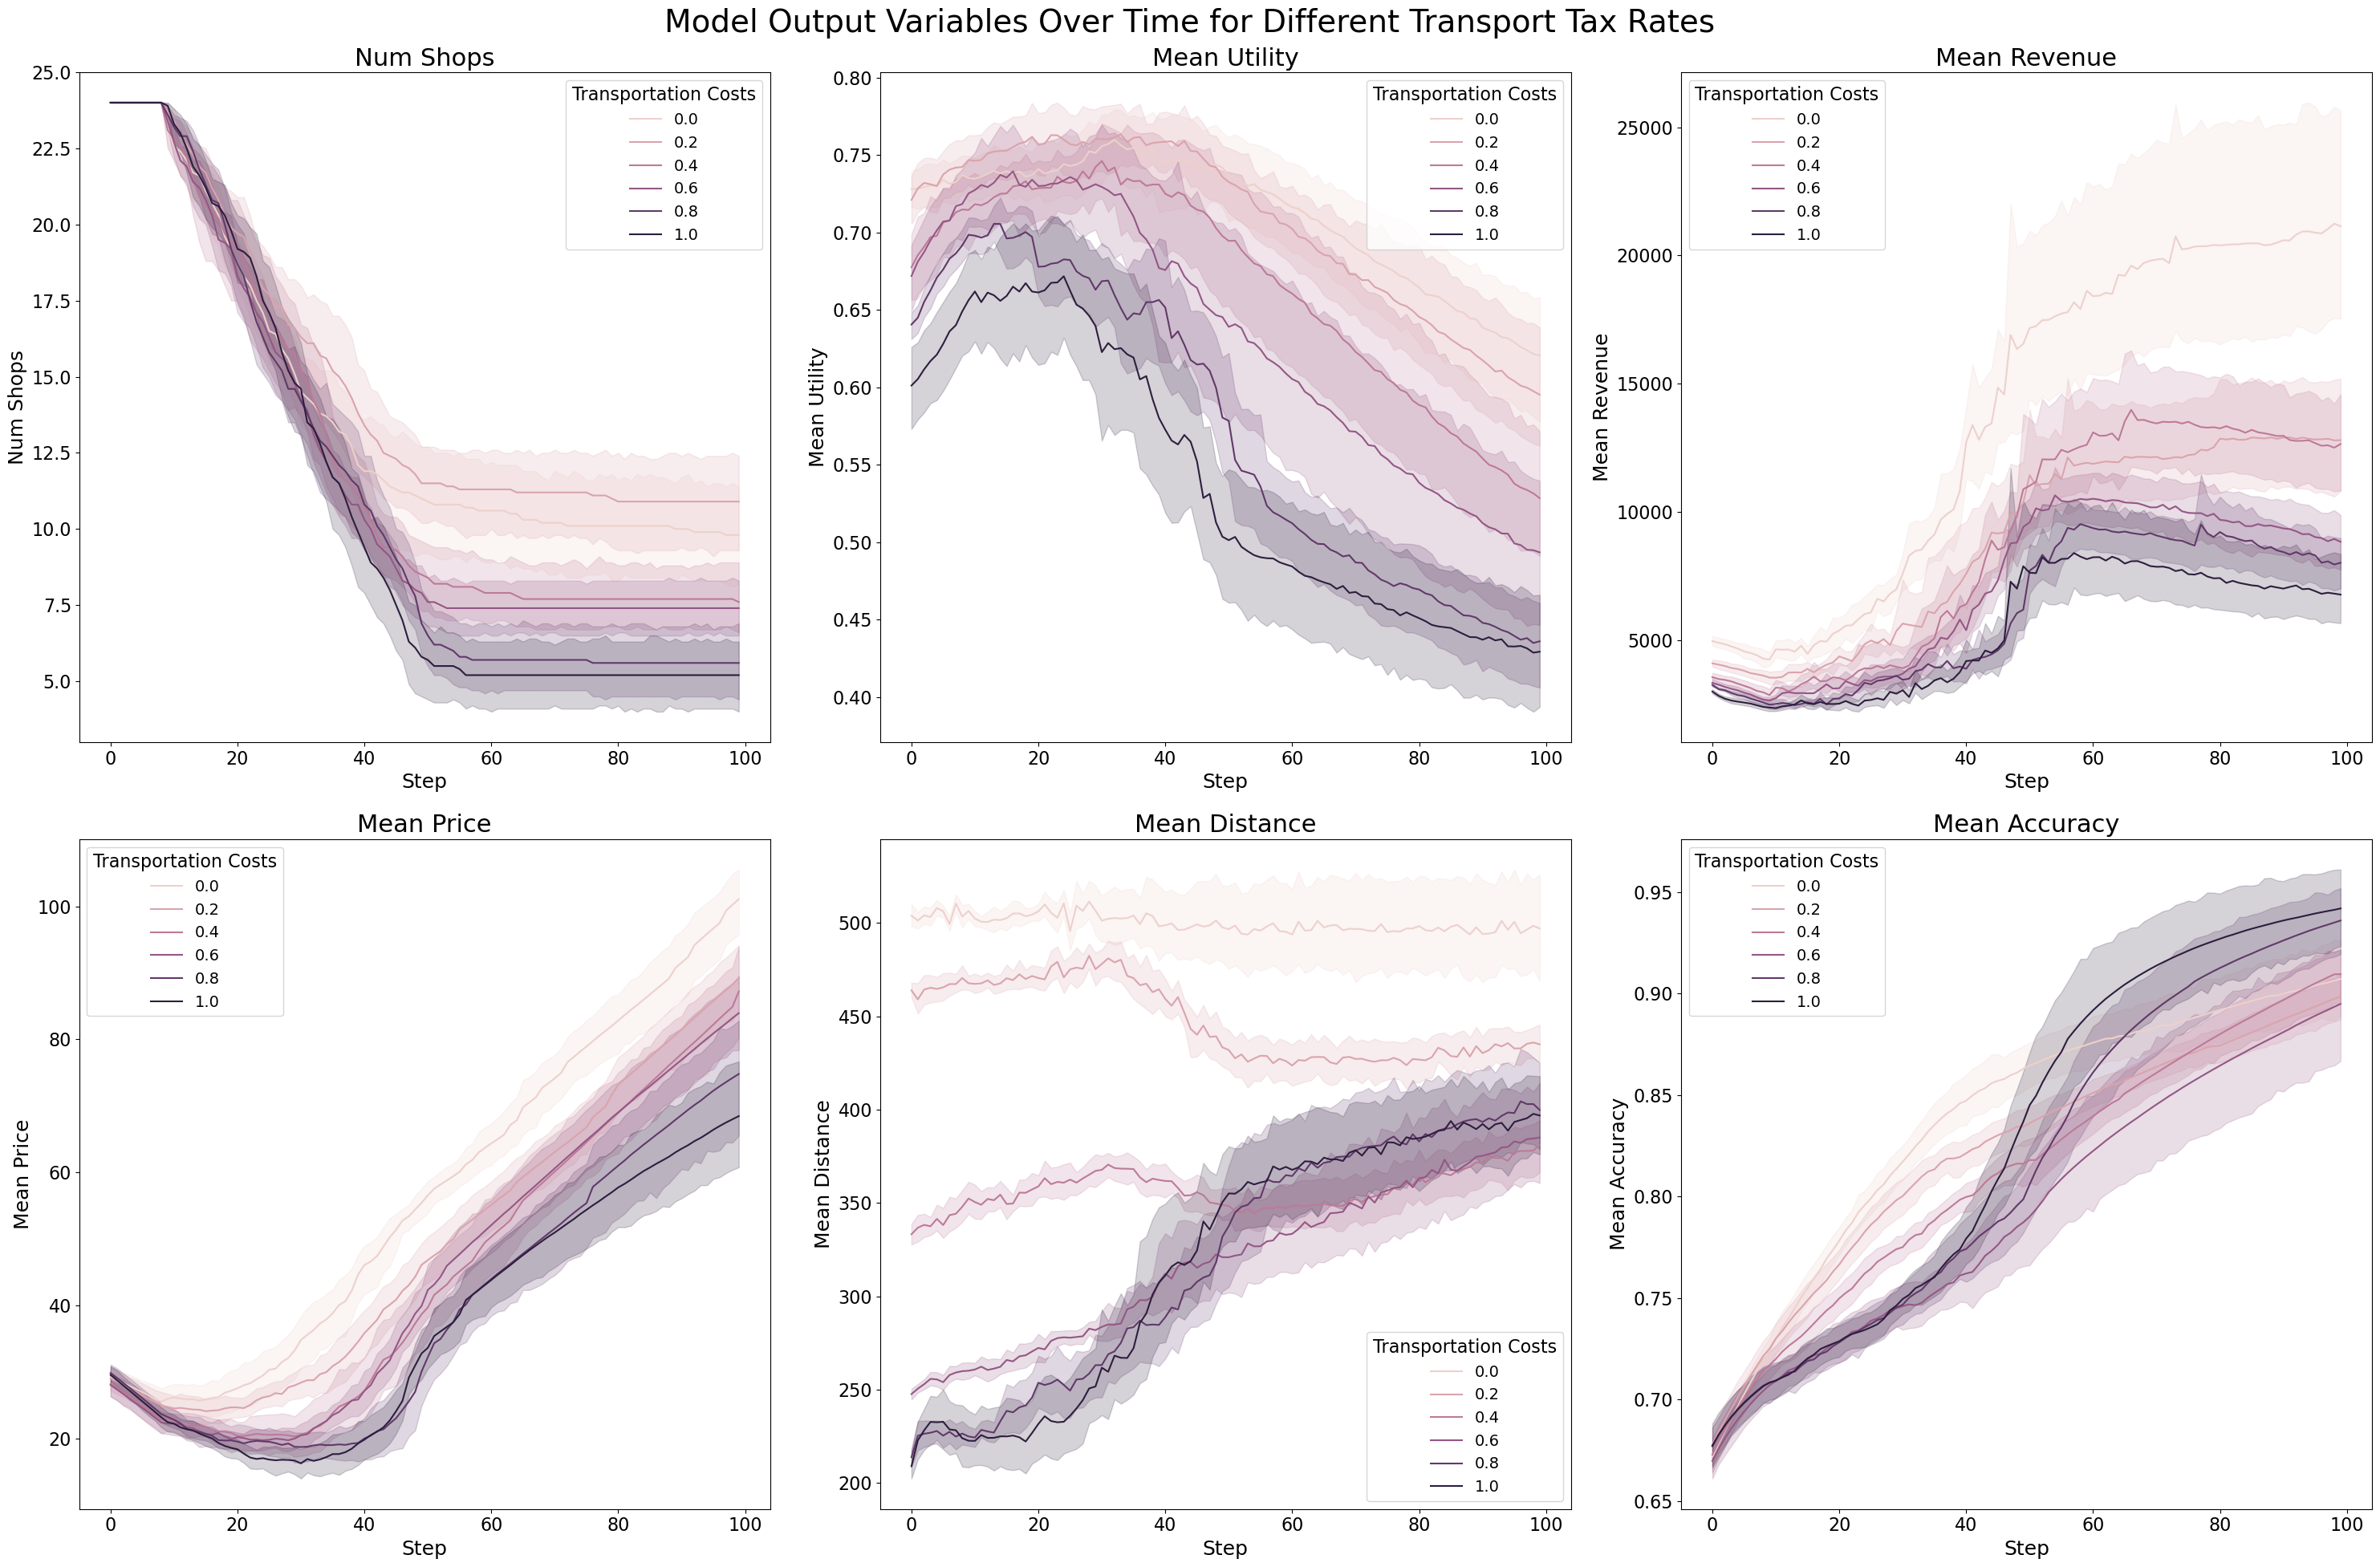

In [7]:
# TODO 5: produce and export a lineplot figure for each of the output variables in results, including confidence intervals
df = pd.DataFrame(results, columns=['transportation_costs', 'sim', 'step', 'num_shops', 'mean_utility', 'mean_revenue', 'mean_price', 'mean_distance', 'mean_accuracy'])

# Create figure with 2x3 subplots
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 3, figsize=(30, 20))
fig.suptitle('Model Output Variables Over Time for Different Transport Tax Rates', fontsize=28)
# Flatten the axes array for easier iteration
axes = axes.flatten()

# List of output variables
output_variables = ['num_shops', 'mean_utility', 'mean_revenue', 'mean_price', 'mean_distance', 'mean_accuracy']

# Create a plot for each variable
for i, var in enumerate(output_variables):
    sns.lineplot(data=df, x='step', y=var, hue='transportation_costs', 
                 errorbar=('ci', 95), ax=axes[i])
    axes[i].set_title(var.replace("_", " ").title(), fontsize=22)
    axes[i].set_xlabel('Step', fontsize=18)
    axes[i].set_ylabel(var.replace("_", " ").title(), fontsize=18)
    axes[i].tick_params(labelsize=16)
    axes[i].legend(title='Transportation Costs', fontsize=14, title_fontsize=16)

# Adjust the layout and save the figure
plt.tight_layout()
fig.subplots_adjust(top=0.94)  # Adjust to prevent title overlap
plt.savefig('combined_output_variables_plot_orig.png', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

# Sensitivity Test #1- Change Quality Weights in Utility Function to Model

In [9]:
#No changes were necessary to the shop or agent classes

# Add weight quality input        
class Model:    
    def __init__(self, transportation_costs, gdf, sim, w_quality):
        '''Create a Model object. Inputs: transportation costs parameter value (int), gdf - GeoDataFrame of building locations and uses, 
        simulation number (int), w_quality - quality weight in the utility function'''
        
        # set parameter values
        self.transportation_costs = transportation_costs # travel tax rate
        self.w_quality = w_quality   # Quality weight in utility function is now an input
        self.utility_threshold = 0.6 # minimal utility agents look for in venue
        self.sim = sim # simulation number
        
        # create venues based on commercial buildings in the GeoDataFrame
        self.venues = [Shop(row.geometry, random(), randint(10, 50), randint(1000, 10000)) for idx, row in gdf.iterrows() if row.landuse=='commercial']
        # create agents located inside residential buildings
        self.agents = [Agent(row.geometry, randint(200, 400), randint(1, 10)) for idx, row in gdf.iterrows() if row.landuse!='commercial']        
        
        for a in self.agents: # initiate agent's cognitive maps with random quality value for all venues
            a.cognitive_map = {v:random() for v in self.venues}
        
        self.data = [] # used to store model outputs
    
    def run_model(self):
        '''Runs 100 simulation iterations and stores outputs in the data attribute'''
        
        for i in range(100): # run 100 iterations
            # reset output variables
            self.utilities = 0 
            self.revenues = 0
            self.distances = 0
            
            for a in self.agents: # agents consume
                a.step()
            
            for b in self.venues: # shops update prices
                b.step()
            
            # compute mean utility, revenue, price, travel distance, and cognitive map accuracy
            mean_utility = self.utilities / len(self.agents)
            mean_revenue = self.revenues / len(self.venues)
            mean_price = sum([v.price for v in self.venues]) / len(self.venues)
            mean_distance = self.distances / len(self.agents)
            mean_accuracy = sum([1-abs(a.cognitive_map[v]-v.quality) for a in self.agents for v in self.venues]) / (len(self.agents) * len(self.venues))
            
            # append to data - transportation costs, simulation number, step number,
            # number of open shops, average utility derived from purchase per agent, 
            # average revenue per shop, average price per shop, average cognitive map accuracy
            self.data.append([self.w_quality, self.sim, i, 
                              len(self.venues), mean_utility, mean_revenue, mean_price, mean_distance, mean_accuracy])


In [10]:
results = []
# TODO 4: read 'bldgs_points' shapefile into a GeoDataFrame named gdf
gdf = gpd.read_file(bld_shp_path)

for w_quality in [0.1, 0.3, 0.5, 0.7, 0.9]: # iterate over values of quality weights
    for i in range(10): # simulate 10 times
        transport_cost = 0.4 # Fixed transportation cost to optimal value selected earlier
        print(w_quality, i)
        model = Model(transport_cost, gdf, i, w_quality)
        model.run_model()
        for d in model.data: # add outputs to results
            results.append(d)

0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.3 0
0.3 1
0.3 2
0.3 3
0.3 4
0.3 5
0.3 6
0.3 7
0.3 8
0.3 9
0.5 0
0.5 1
0.5 2
0.5 3
0.5 4
0.5 5
0.5 6
0.5 7
0.5 8
0.5 9
0.7 0
0.7 1
0.7 2
0.7 3
0.7 4
0.7 5
0.7 6
0.7 7
0.7 8
0.7 9
0.9 0
0.9 1
0.9 2
0.9 3
0.9 4
0.9 5
0.9 6
0.9 7
0.9 8
0.9 9


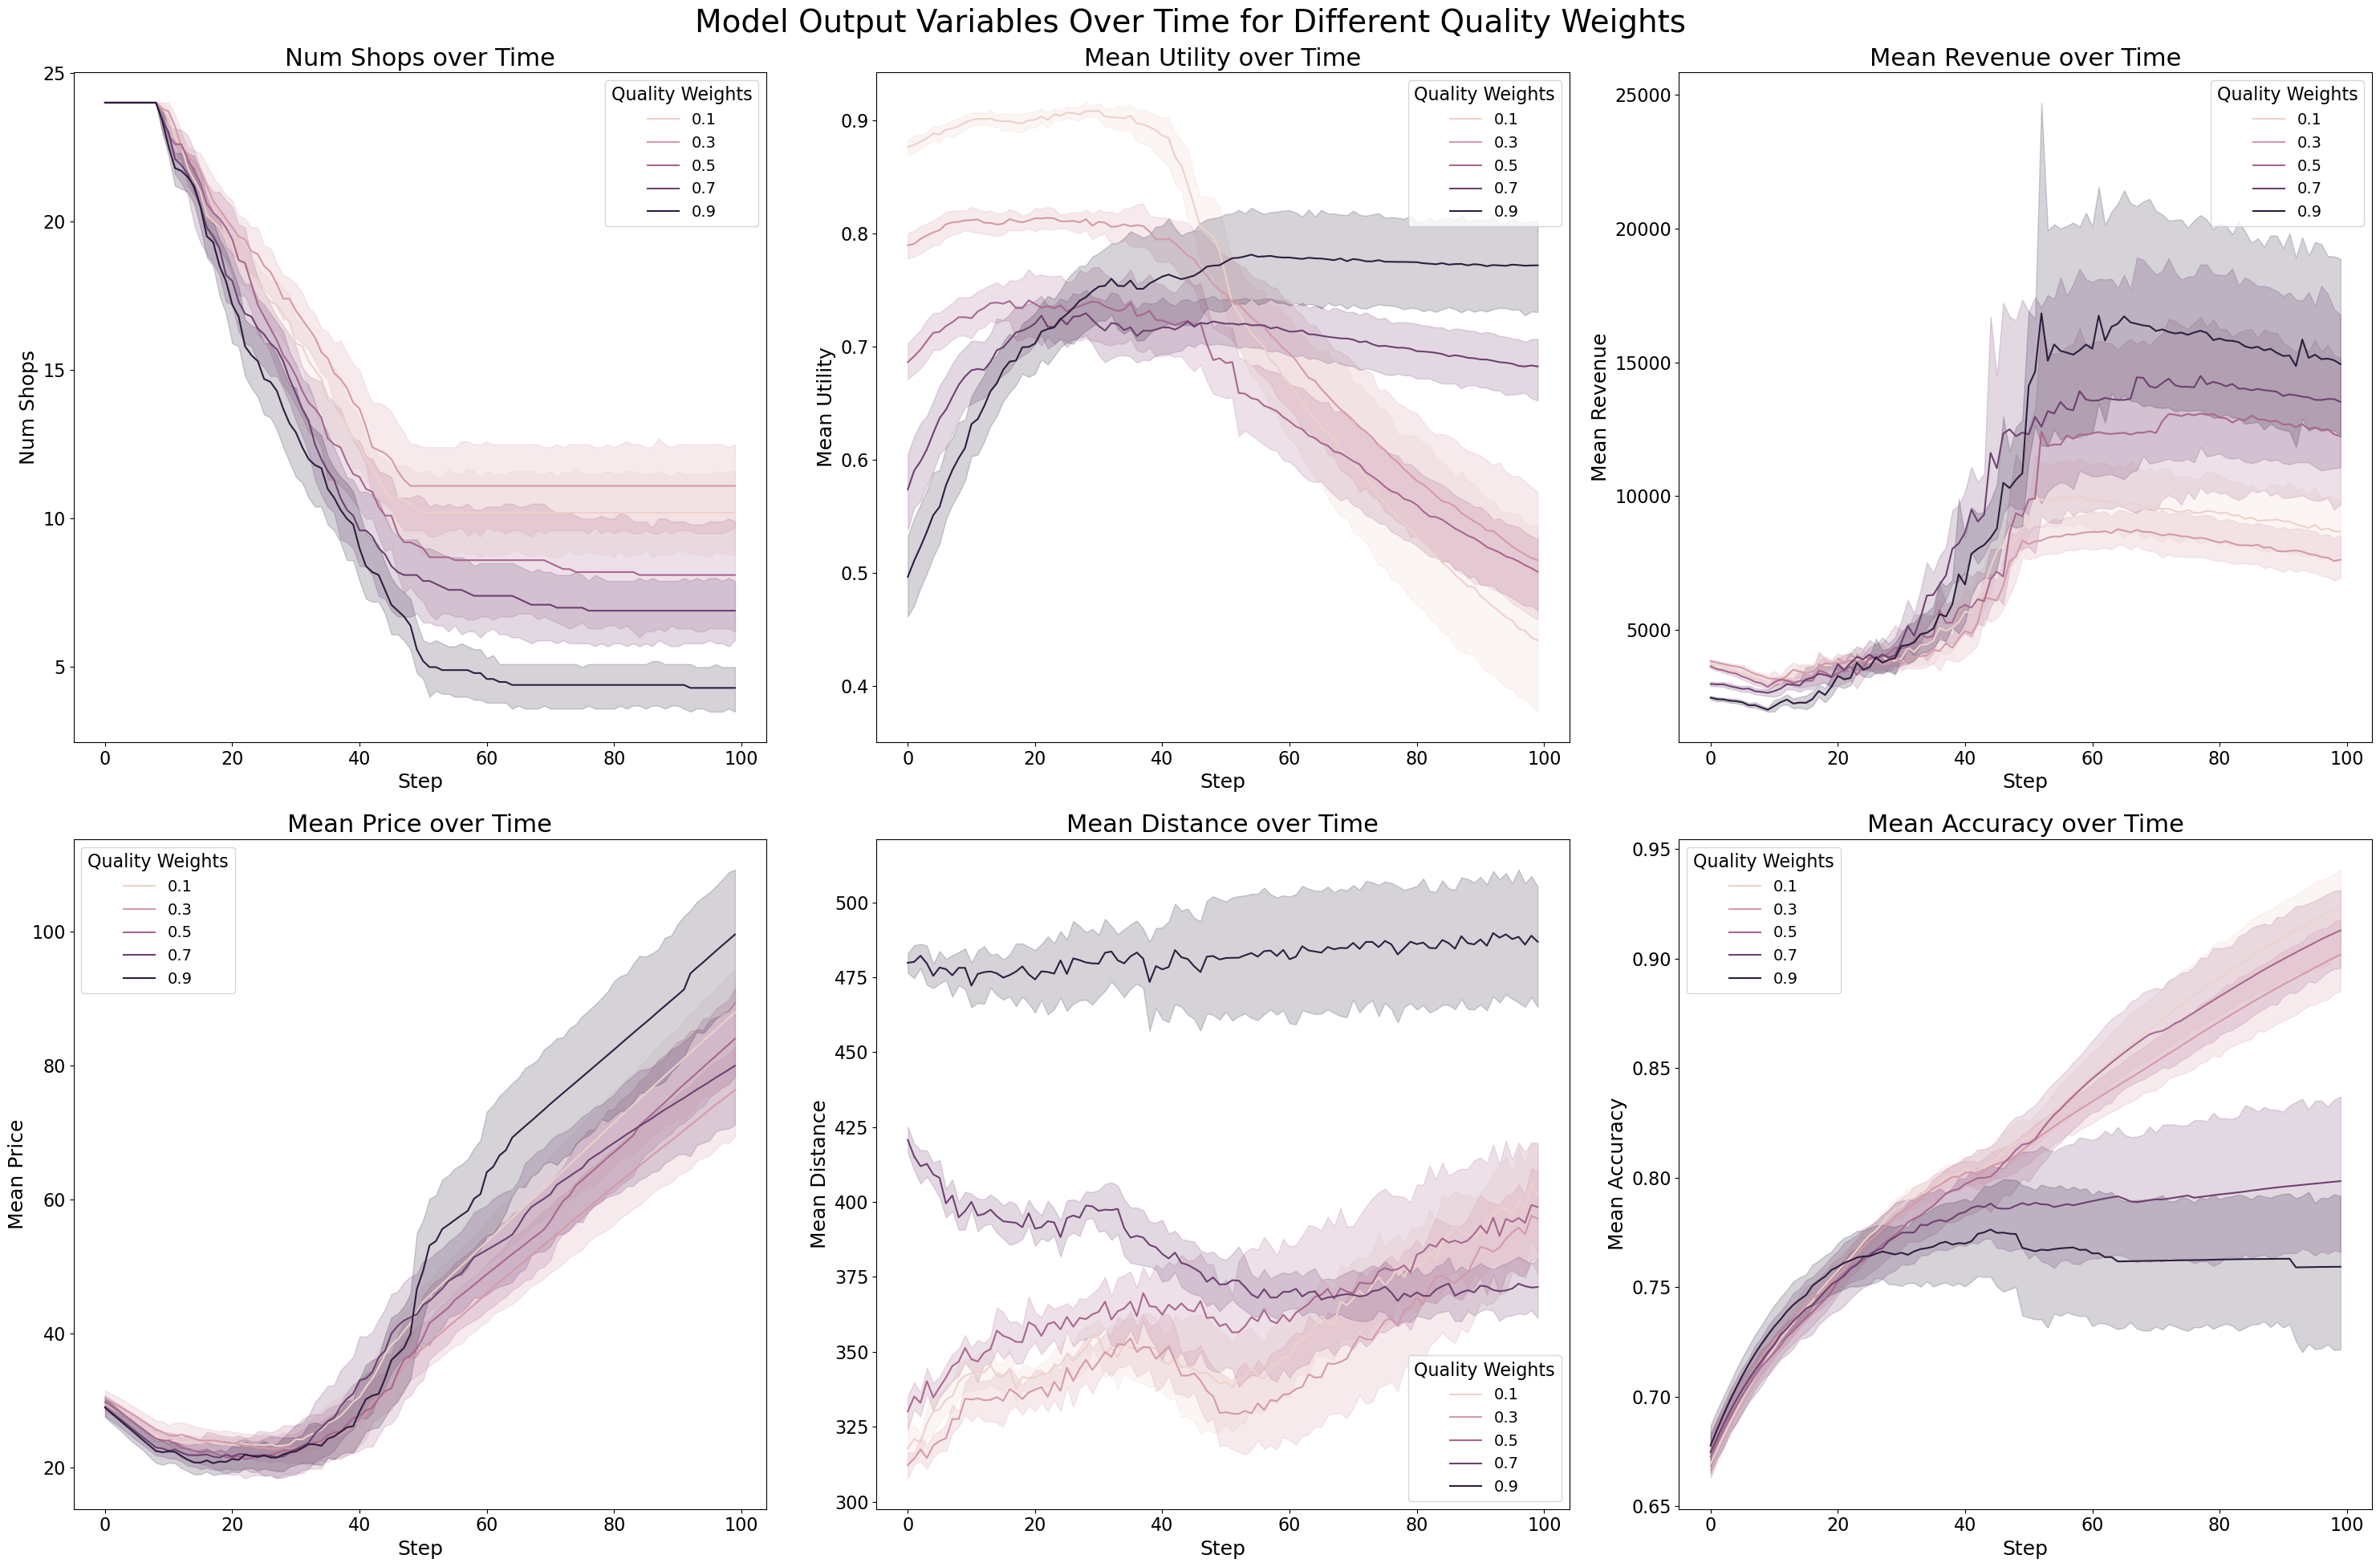

In [11]:
# TODO 5: produce and export a lineplot figure for each of the output variables in results, including confidence intervals
df = pd.DataFrame(results, columns=['w_quality', 'sim', 'step', 'num_shops', 'mean_utility', 'mean_revenue', 'mean_price', 'mean_distance', 'mean_accuracy'])

# Create figure with 2x3 subplots
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 3, figsize=(30, 20))
fig.suptitle('Model Output Variables Over Time for Different Quality Weights', fontsize=28)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# List of output variables
output_variables = ['num_shops', 'mean_utility', 'mean_revenue', 'mean_price', 'mean_distance', 'mean_accuracy']

# Create a plot for each variable
for i, var in enumerate(output_variables):
    sns.lineplot(data=df, x='step', y=var, hue='w_quality', 
                 errorbar=('ci', 95), ax=axes[i])
    axes[i].set_title(f'{var.replace("_", " ").title()} over Time', fontsize=22)
    axes[i].set_xlabel('Step', fontsize=18)
    axes[i].set_ylabel(var.replace("_", " ").title(), fontsize=18)
    axes[i].tick_params(labelsize=16)
    axes[i].legend(title='Quality Weights', fontsize=14, title_fontsize=16)

# Adjust the layout and save the figure
plt.tight_layout()
fig.subplots_adjust(top=0.94)  # Adjust to prevent title overlap
plt.savefig('quality_weight_sensitivity_analysis.png', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

# Sensitivity Analysis #2-Update Utility Threshold

In [13]:
#No changes were necessary to the shop or agent classes

# Add utility threshold input
class Model:    
    def __init__(self, transportation_costs, gdf, sim, utility_threshold):
        '''Create a Model object. Inputs: transportation costs parameter value (int), gdf - GeoDataFrame of building locations and uses, 
        simulation number (int), utility_threshold - minimal utility agents look for in venue'''
        
        # set parameter values
        self.transportation_costs = transportation_costs # travel tax rate
        self.w_quality = 0.5 # weight of quality in utility function
        # Changed attribute to be an input instead of a fixed value like in the original code (where it was fixed at 0.6)\
        self.utility_threshold = utility_threshold # Inputted minimal utility agents look for in venue
        self.sim = sim # simulation number
        
        # create venues based on commercial buildings in the GeoDataFrame
        self.venues = [Shop(row.geometry, random(), randint(10, 50), randint(1000, 10000)) for idx, row in gdf.iterrows() if row.landuse=='commercial']
        # create agents located inside residential buildings
        self.agents = [Agent(row.geometry, randint(200, 400), randint(1, 10)) for idx, row in gdf.iterrows() if row.landuse!='commercial']        
        
        for a in self.agents: # initiate agent's cognitive maps with random quality value for all venues
            a.cognitive_map = {v:random() for v in self.venues}
        
        self.data = [] # used to store model outputs
    
    def run_model(self):
        '''Runs 100 simulation iterations and stores outputs in the data attribute'''
        
        for i in range(100): # run 100 iterations
            # reset output variables
            self.utilities = 0 
            self.revenues = 0
            self.distances = 0
            
            for a in self.agents: # agents consume
                a.step()
            
            for b in self.venues: # shops update prices
                b.step()
            
            # compute mean utility, revenue, price, travel distance, and cognitive map accuracy
            mean_utility = self.utilities / len(self.agents)
            mean_revenue = self.revenues / len(self.venues)
            mean_price = sum([v.price for v in self.venues]) / len(self.venues)
            mean_distance = self.distances / len(self.agents)
            mean_accuracy = sum([1-abs(a.cognitive_map[v]-v.quality) for a in self.agents for v in self.venues]) / (len(self.agents) * len(self.venues))
            
            # append to data - transportation costs, simulation number, step number,
            # number of open shops, average utility derived from purchase per agent, 
            # average revenue per shop, average price per shop, average cognitive map accuracy
            self.data.append([self.utility_threshold, self.sim, i, 
                              len(self.venues), mean_utility, mean_revenue, mean_price, mean_distance, mean_accuracy])

In [14]:
# Runs the sensitivity analysis for 5 different utility thresholds

results = []

for utility_threshold in [0.2, 0.4, 0.6, 0.8, 1.0]:  # testing 5 values for utility threshold
    for i in range(10):  # simulate 10 times for each utility threshold
        transport_cost = 0.4  # Fixed transportation cost
        print(f"Utility Threshold: {utility_threshold}, Simulation: {i}")
        model = Model(transport_cost, gdf, i, utility_threshold)
        model.run_model()
        for d in model.data:  # add outputs to results
            results.append(d)

Utility Threshold: 0.2, Simulation: 0
Utility Threshold: 0.2, Simulation: 1
Utility Threshold: 0.2, Simulation: 2
Utility Threshold: 0.2, Simulation: 3
Utility Threshold: 0.2, Simulation: 4
Utility Threshold: 0.2, Simulation: 5
Utility Threshold: 0.2, Simulation: 6
Utility Threshold: 0.2, Simulation: 7
Utility Threshold: 0.2, Simulation: 8
Utility Threshold: 0.2, Simulation: 9
Utility Threshold: 0.4, Simulation: 0
Utility Threshold: 0.4, Simulation: 1
Utility Threshold: 0.4, Simulation: 2
Utility Threshold: 0.4, Simulation: 3
Utility Threshold: 0.4, Simulation: 4
Utility Threshold: 0.4, Simulation: 5
Utility Threshold: 0.4, Simulation: 6
Utility Threshold: 0.4, Simulation: 7
Utility Threshold: 0.4, Simulation: 8
Utility Threshold: 0.4, Simulation: 9
Utility Threshold: 0.6, Simulation: 0
Utility Threshold: 0.6, Simulation: 1
Utility Threshold: 0.6, Simulation: 2
Utility Threshold: 0.6, Simulation: 3
Utility Threshold: 0.6, Simulation: 4
Utility Threshold: 0.6, Simulation: 5
Utility Thre

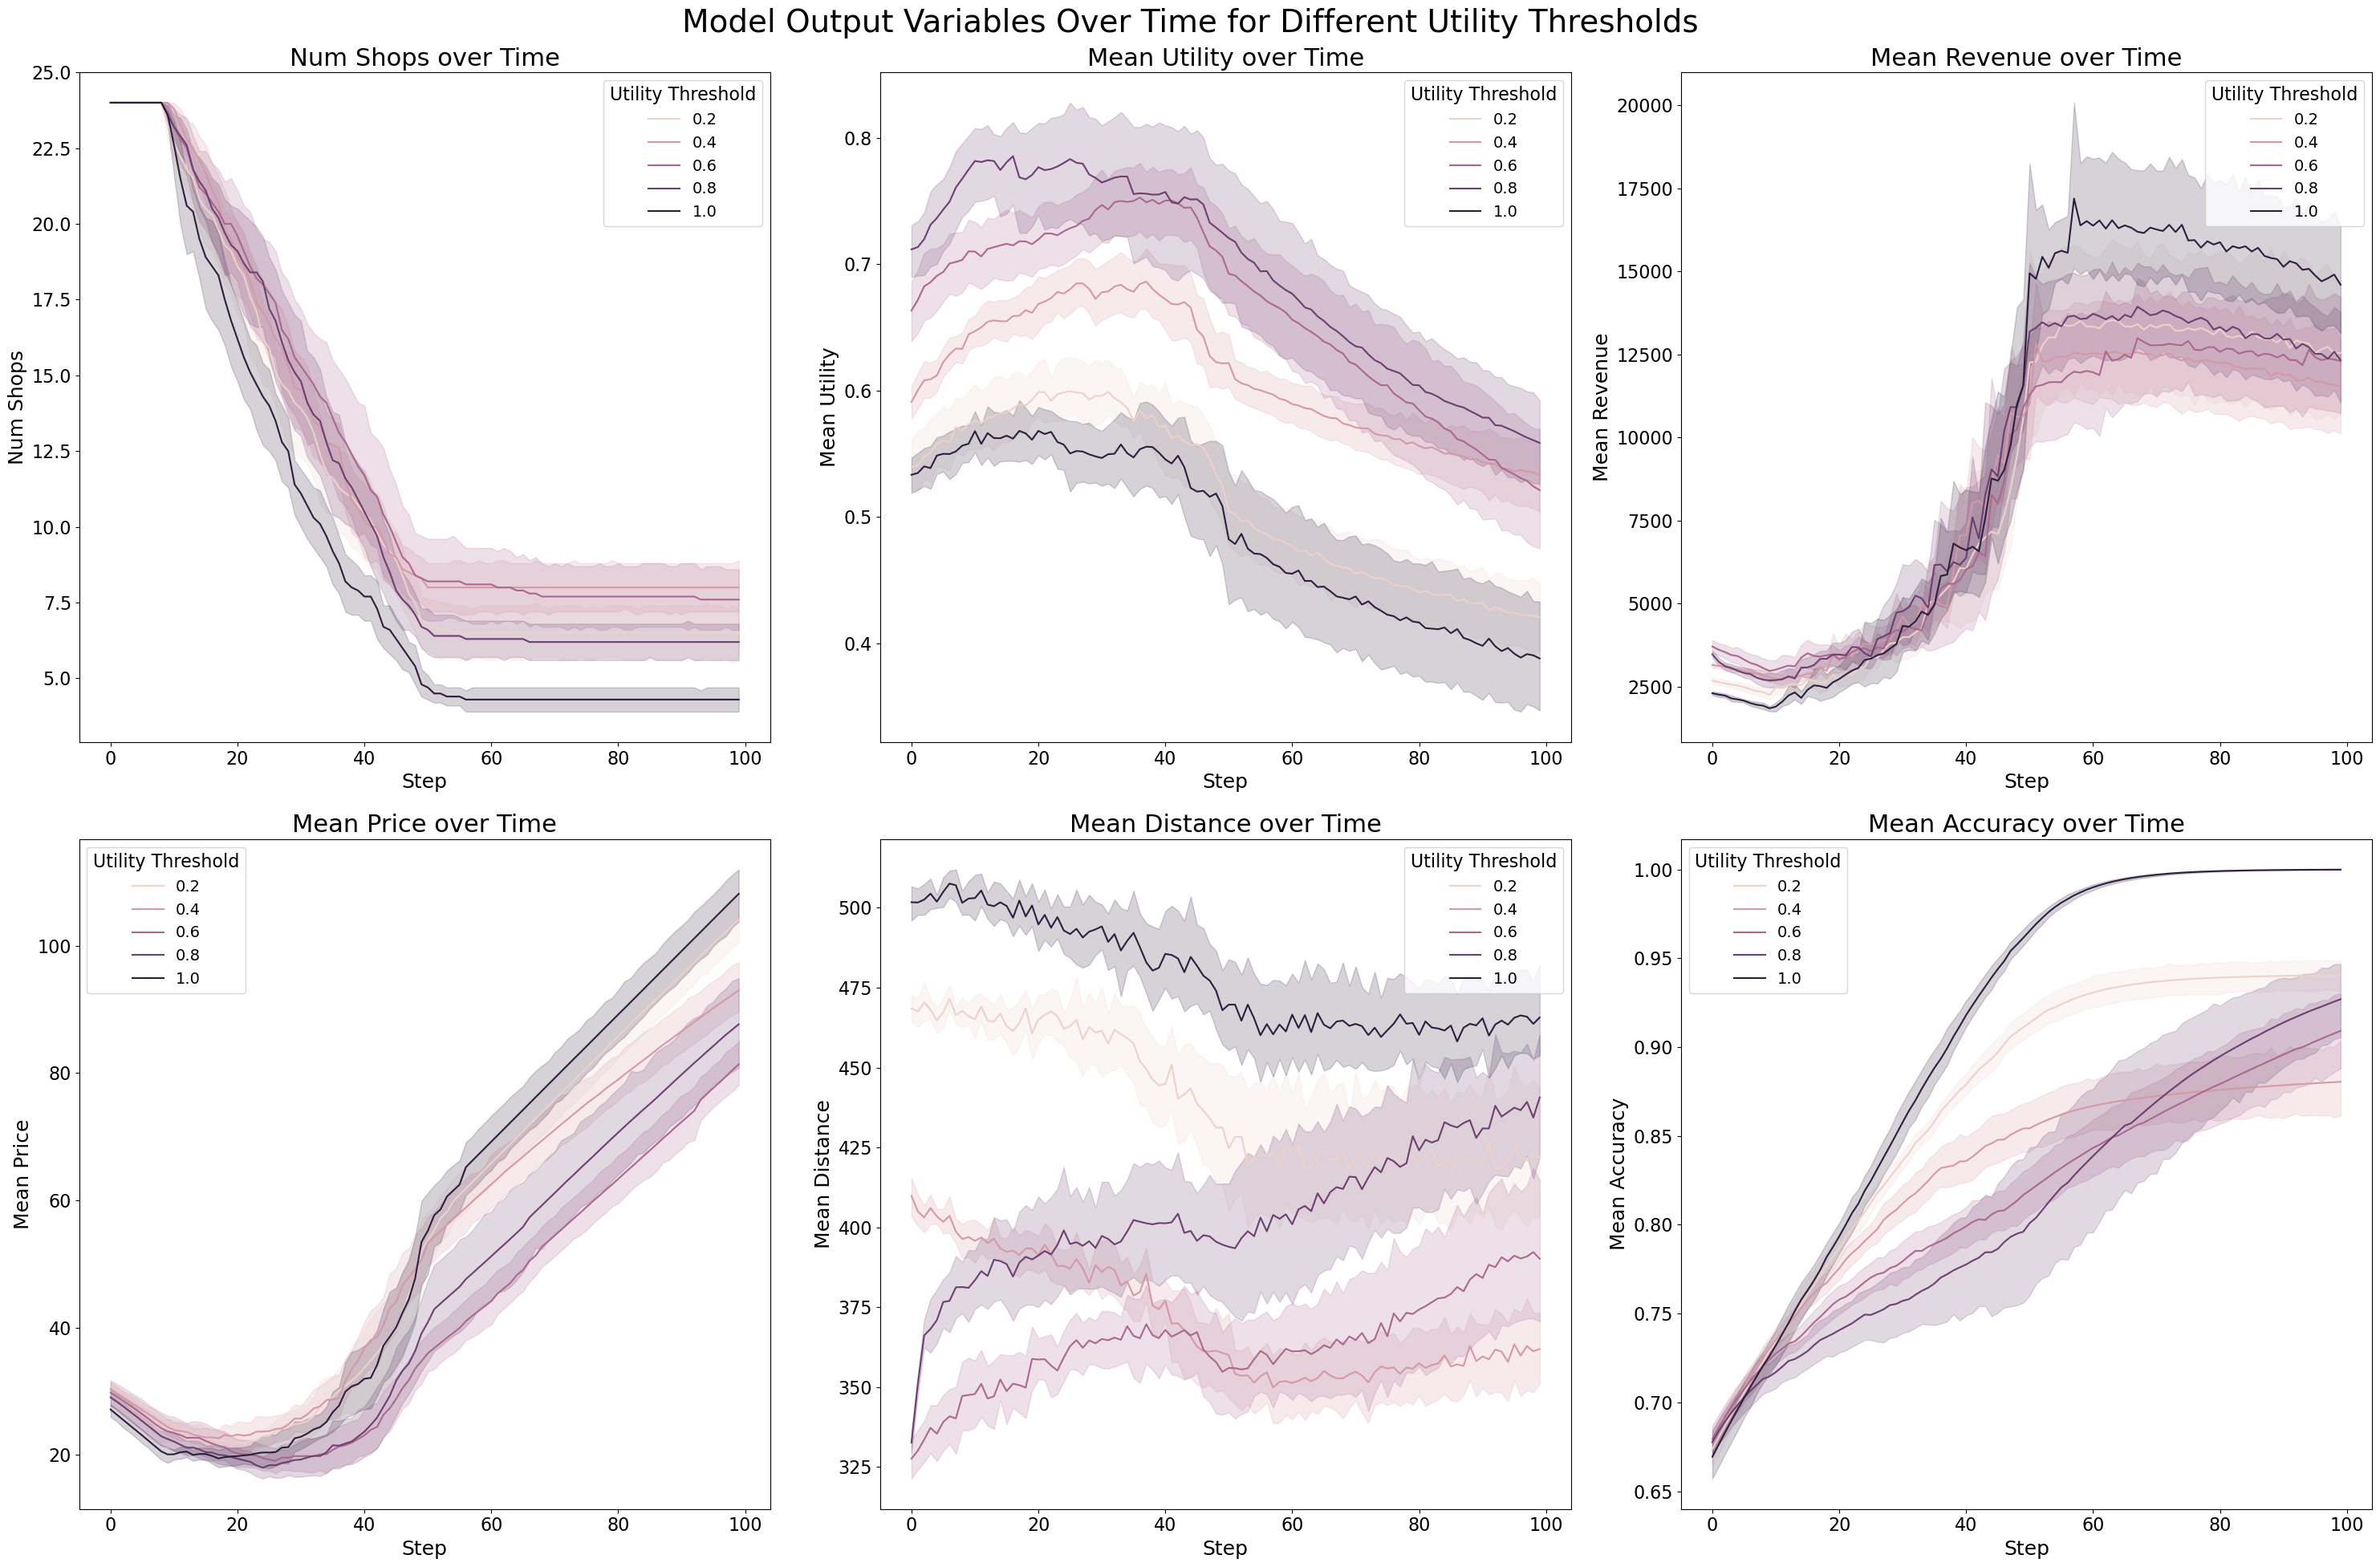

In [15]:
# TODO 5: produce and export a lineplot figure for each of the output variables in results, including confidence intervals

df = pd.DataFrame(results, columns=['utility_threshold', 'sim', 'step', 'num_shops', 'mean_utility', 'mean_revenue', 'mean_price', 'mean_distance', 'mean_accuracy'])


plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 3, figsize=(30, 20))
fig.suptitle('Model Output Variables Over Time for Different Utility Thresholds', fontsize=28)
axes = axes.flatten()
output_variables = ['num_shops', 'mean_utility', 'mean_revenue', 'mean_price', 'mean_distance', 'mean_accuracy']

for i, var in enumerate(output_variables):
    sns.lineplot(data=df, x='step', y=var, hue='utility_threshold', 
                 errorbar=('ci', 95), ax=axes[i])
    axes[i].set_title(f'{var.replace("_", " ").title()} over Time', fontsize=22)
    axes[i].set_xlabel('Step', fontsize=18)
    axes[i].set_ylabel(var.replace("_", " ").title(), fontsize=18)
    axes[i].tick_params(labelsize=16)
    axes[i].legend(title='Utility Threshold', fontsize=14, title_fontsize=16)

plt.tight_layout()
fig.subplots_adjust(top=0.94)
plt.savefig('utility_threshold_sensitivity_analysis.png', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

# Sensitivity Analysis #3 Bankruptcy Threshold

In [17]:
# No changes were necessary to the agent class

# Add bankruptcy threshold input and incorporated into step function
class Shop:    
    def __init__(self, geometry, quality, price, operation_costs, bankruptcy_threshold):
        '''Create a Shop object, inputs:\n
        geometry = location of shop, Shapely geometry object\n
        quality = quality of product in the shop, float (range 0 to 1)\n
        price = price per product unit in the shop, int (range 0 to inf)\n
        operation_costs = total operation costs for the shop, int (range 0 to inf)\n
        bankruptcy_threshold = number of consecutive unprofitable periods before bankruptcy'''
        
        self.geometry = geometry
        self.quality = quality
        self.price = price
        self.operation_costs = operation_costs
        # Added bankruptcy threshold attribute
        self.bankruptcy_threshold = bankruptcy_threshold
        
        self.revenue = 0 # used to keep track of revenue during each iteration
        # Added for use in calculating when bankruptcy threshold is exceeded
        self.unprofitable_periods = 0 # counter for consecutive unprofitable periods
    
    def dist(self, geom):
        '''Compute aerial distance between object and geometry object geom'''
        return self.geometry.distance(geom)
    
    def step(self):
        '''Determines change in price according to shops revenue and operation costs'''
        
        model.revenues += self.revenue # increase model variable to document revenue
        if self.revenue < self.operation_costs: # if the shop is not profitable
            self.price = max(1, self.price - 1)  # decrease price, but not below 1
            
            # Tests if bankruptcy threshold is met, if it is, business is removed
            self.unprofitable_periods += 1
            if self.unprofitable_periods >= self.bankruptcy_threshold: # if consistently unprofitable, remove from model
                model.venues.remove(self) # delete object from model's list of venues
                for a in model.agents: # remove venue from agents' cognitive maps
                    del a.cognitive_map[self]
        else:
            self.unprofitable_periods = 0 # reset counter of unprofitable periods if profitable
            if self.revenue >= 2 * self.operation_costs: # if profits are high - increase price
                self.price += 1
        self.revenue = 0 # reset revenue for next round



class Model:    
    def __init__(self, transportation_costs, gdf, sim, bankruptcy_threshold):
        '''Create a Model object. Inputs: transportation costs parameter value (int), gdf - GeoDataFrame of building locations and uses, 
        simulation number (int), bankruptcy_threshold - number of consecutive unprofitable periods before bankruptcy'''
        
        # set parameter values
        self.transportation_costs = transportation_costs # travel tax rate
        self.w_quality = 0.5 # weight of quality in utility function
        self.utility_threshold = 0.6 # minimal utility agents look for in venue
        self.sim = sim # simulation number
        self.bankruptcy_threshold = bankruptcy_threshold
        
        # create venues based on commercial buildings in the GeoDataFrame
        self.venues = [Shop(row.geometry, random(), randint(10, 50), randint(1000, 10000), self.bankruptcy_threshold) 
                       for idx, row in gdf.iterrows() if row.landuse=='commercial']
        # create agents located inside residential buildings
        self.agents = [Agent(row.geometry, randint(200, 400), randint(1, 10)) for idx, row in gdf.iterrows() if row.landuse!='commercial']        
        
        for a in self.agents: # initiate agent's cognitive maps with random quality value for all venues
            a.cognitive_map = {v:random() for v in self.venues}
        
        self.data = [] # used to store model outputs
    
    def run_model(self):
        '''Runs 100 simulation iterations and stores outputs in the data attribute'''
        
        for i in range(100): # run 100 iterations
            # reset output variables
            self.utilities = 0 
            self.revenues = 0
            self.distances = 0
            
            for a in self.agents: # agents consume
                a.step()
            
            for b in self.venues: # shops update prices
                b.step()
            
            # compute mean utility, revenue, price, travel distance, and cognitive map accuracy
            mean_utility = self.utilities / len(self.agents)
            mean_revenue = self.revenues / len(self.venues)
            mean_price = sum([v.price for v in self.venues]) / len(self.venues)
            mean_distance = self.distances / len(self.agents)
            mean_accuracy = sum([1-abs(a.cognitive_map[v]-v.quality) for a in self.agents for v in self.venues]) / (len(self.agents) * len(self.venues))
            
            # append to data - transportation costs, simulation number, step number,
            # number of open shops, average utility derived from purchase per agent, 
            # average revenue per shop, average price per shop, average cognitive map accuracy
            self.data.append([self.bankruptcy_threshold, self.sim, i, 
                              len(self.venues), mean_utility, mean_revenue, mean_price, mean_distance, mean_accuracy])

In [18]:
# Runs the sensitivity analysis for 5 different bankruptcy thresholds

results = []
# TODO 4: read 'bldgs_points' shapefile into a GeoDataFrame named gdf
gdf = gpd.read_file(bld_shp_path)

for bankruptcy_threshold in [1, 3, 5, 7, 9]:  # testing 5 values for bankruptcy threshold
    for i in range(10):  # simulate 10 times for each bankruptcy threshold
        transport_cost = 0.4  # fixed transportation cost
        print(f"Bankruptcy Threshold: {bankruptcy_threshold}, Simulation: {i}")
        model = Model(transport_cost, gdf, i, bankruptcy_threshold)
        model.run_model()
        for d in model.data:  # add outputs to results
            results.append(d)

Bankruptcy Threshold: 1, Simulation: 0
Bankruptcy Threshold: 1, Simulation: 1
Bankruptcy Threshold: 1, Simulation: 2
Bankruptcy Threshold: 1, Simulation: 3
Bankruptcy Threshold: 1, Simulation: 4
Bankruptcy Threshold: 1, Simulation: 5
Bankruptcy Threshold: 1, Simulation: 6
Bankruptcy Threshold: 1, Simulation: 7
Bankruptcy Threshold: 1, Simulation: 8
Bankruptcy Threshold: 1, Simulation: 9
Bankruptcy Threshold: 3, Simulation: 0
Bankruptcy Threshold: 3, Simulation: 1
Bankruptcy Threshold: 3, Simulation: 2
Bankruptcy Threshold: 3, Simulation: 3
Bankruptcy Threshold: 3, Simulation: 4
Bankruptcy Threshold: 3, Simulation: 5
Bankruptcy Threshold: 3, Simulation: 6
Bankruptcy Threshold: 3, Simulation: 7
Bankruptcy Threshold: 3, Simulation: 8
Bankruptcy Threshold: 3, Simulation: 9
Bankruptcy Threshold: 5, Simulation: 0
Bankruptcy Threshold: 5, Simulation: 1
Bankruptcy Threshold: 5, Simulation: 2
Bankruptcy Threshold: 5, Simulation: 3
Bankruptcy Threshold: 5, Simulation: 4
Bankruptcy Threshold: 5, 

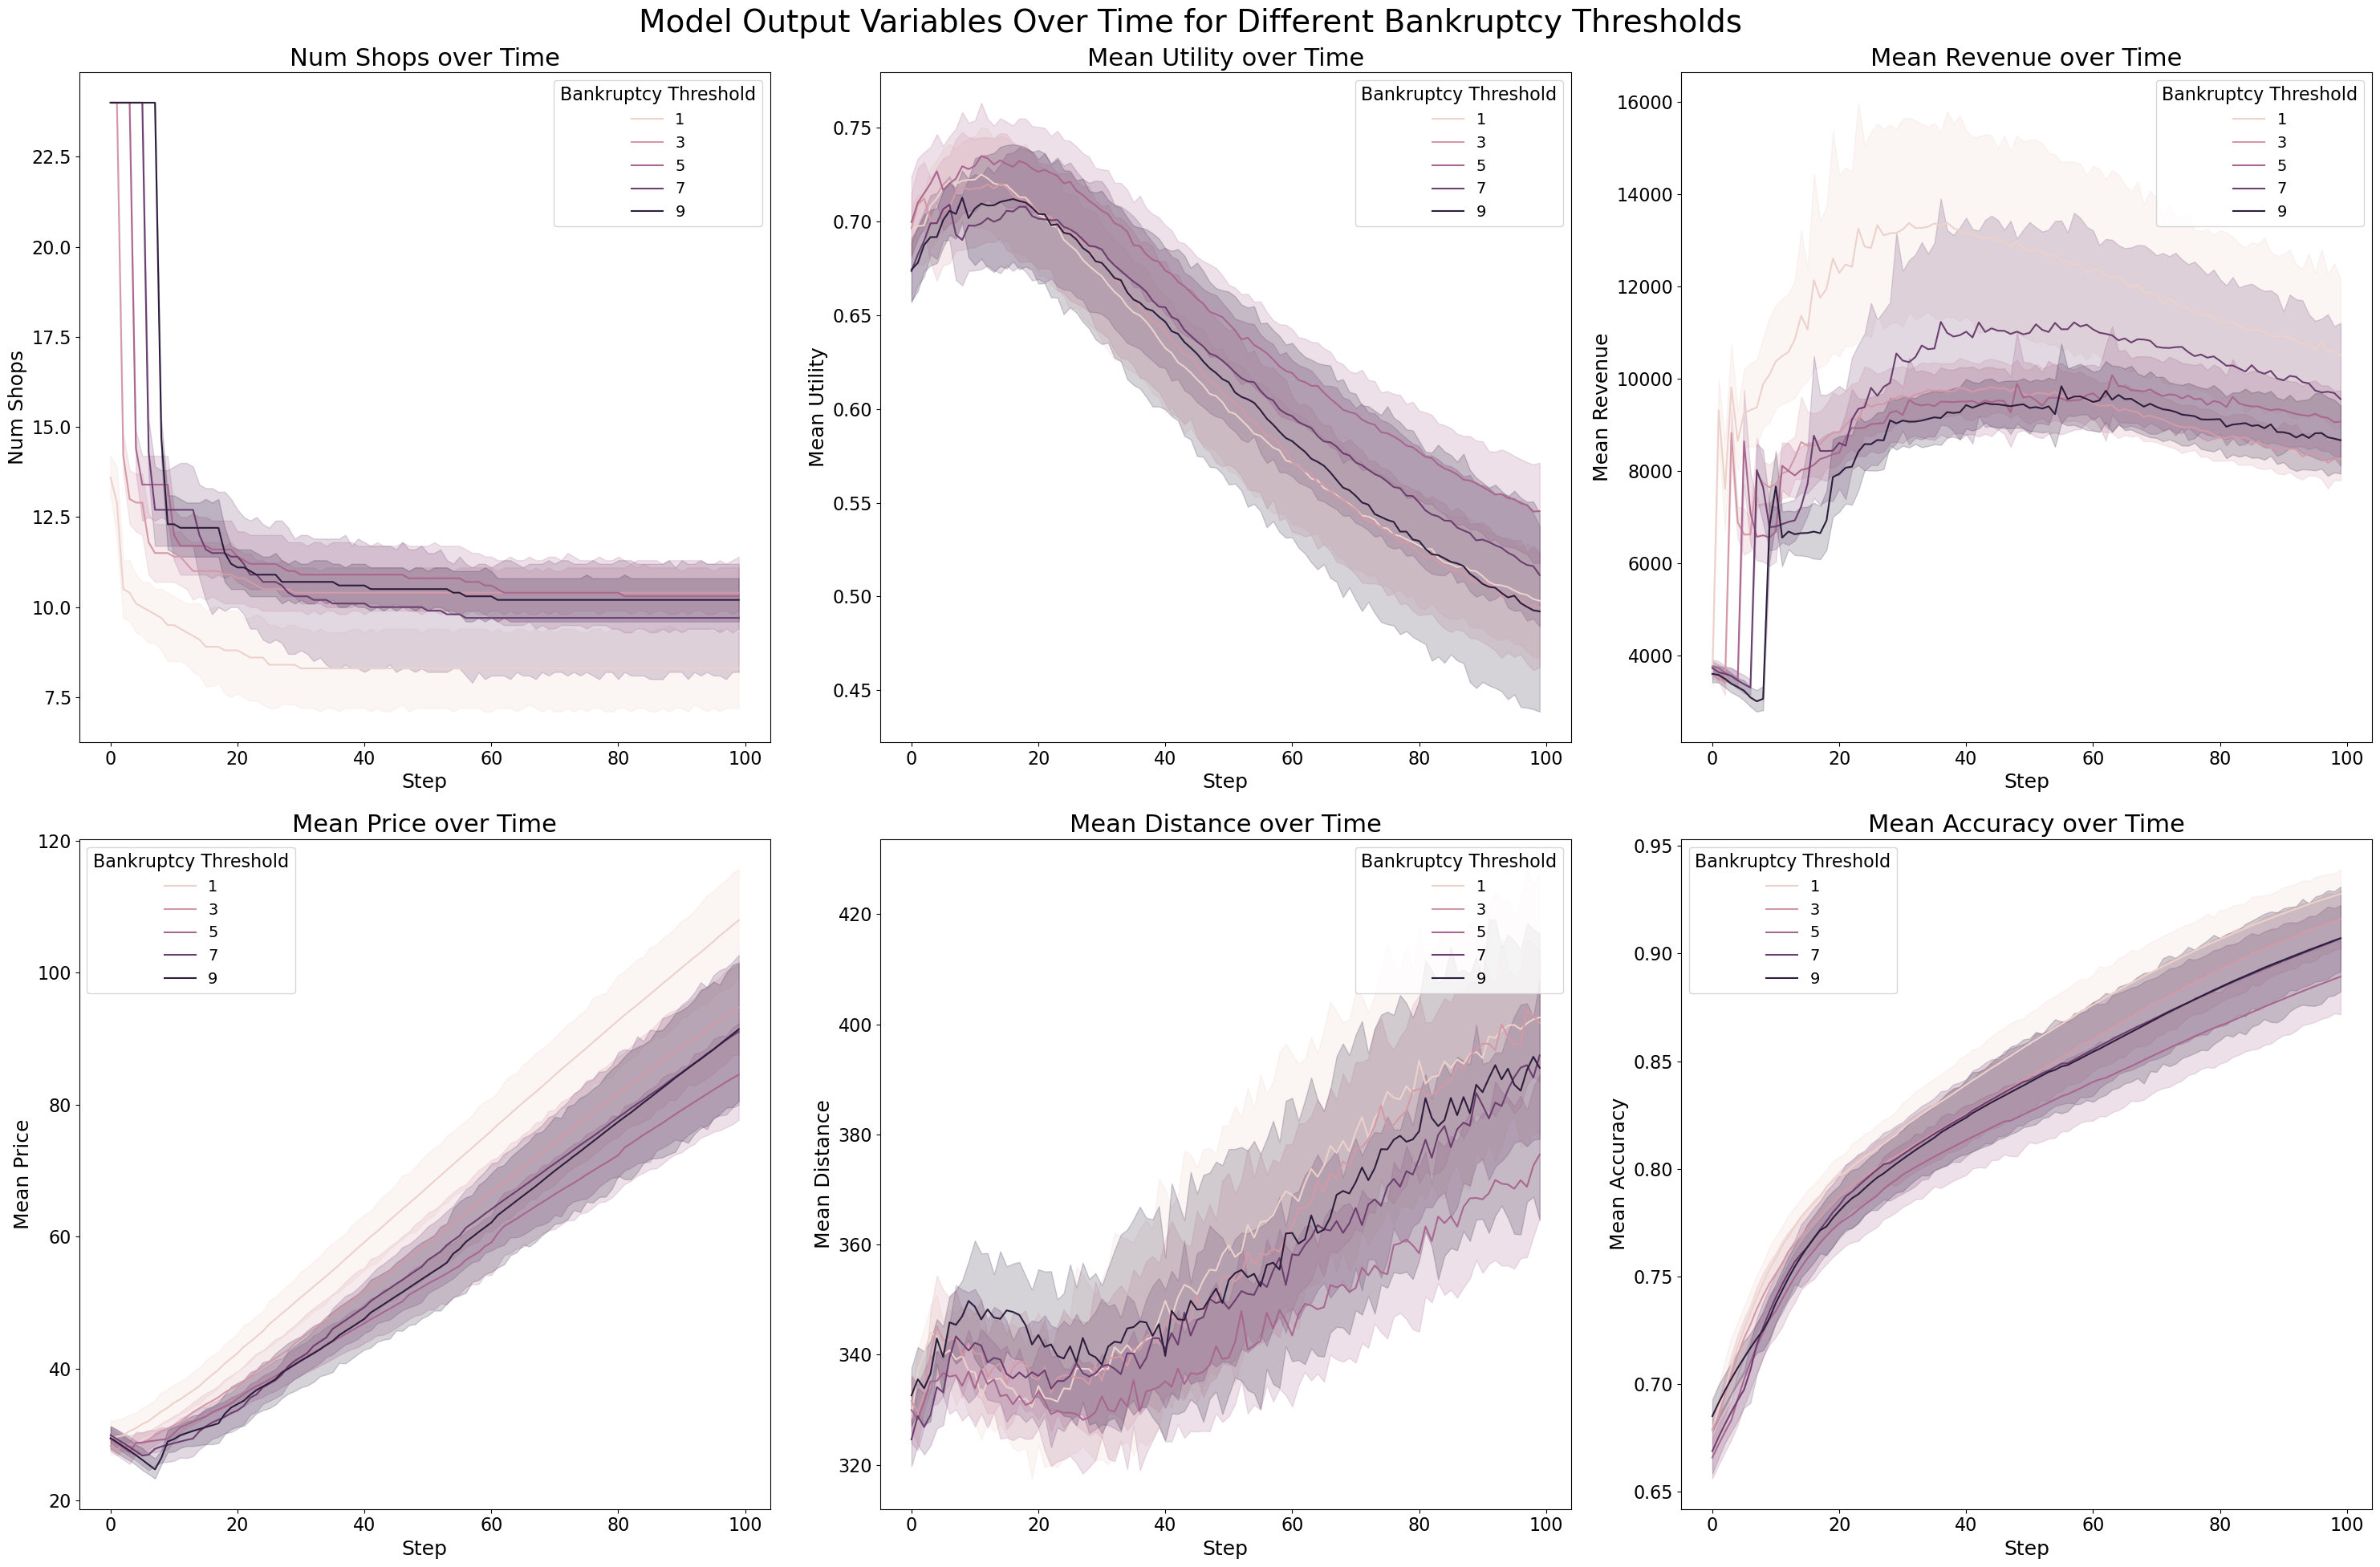

In [19]:
# Saves visualizations of outputs for different bankruptcy thresholds

df = pd.DataFrame(results, columns=['bankruptcy_threshold', 'sim', 'step', 'num_shops', 'mean_utility', 'mean_revenue', 'mean_price', 'mean_distance', 'mean_accuracy'])

# Create figure with 2x3 subplots
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 3, figsize=(30, 20))
fig.suptitle('Model Output Variables Over Time for Different Bankruptcy Thresholds', fontsize=28)
# Flatten the axes array for easier iteration
axes = axes.flatten()

# List of output variables
output_variables = ['num_shops', 'mean_utility', 'mean_revenue', 'mean_price', 'mean_distance', 'mean_accuracy']



for i, var in enumerate(output_variables):
    sns.lineplot(data=df, x='step', y=var, hue='bankruptcy_threshold', 
                 errorbar=('ci', 95), ax=axes[i])
    axes[i].set_title(f'{var.replace("_", " ").title()} over Time', fontsize=22)
    axes[i].set_xlabel('Step', fontsize=18)
    axes[i].set_ylabel(var.replace("_", " ").title(), fontsize=18)
    axes[i].tick_params(labelsize=16)
    axes[i].legend(title='Bankruptcy Threshold', fontsize=14, title_fontsize=16)

plt.tight_layout()
fig.subplots_adjust(top=0.94)
plt.savefig('bankruptcy_threshold_sensitivity_analysis.png', dpi=500, bbox_inches='tight')
plt.show()
plt.close()